#### This notebook contains the K-Means clustering using the perceptual image similarity metric on CIFAR10 data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.cluster import KMeans
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=False)

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
vgg16_feature_extractor = torch.nn.Sequential(*(list(vgg16.children())[:-1]))  # Remove the last fully connected layer

# Set the model to evaluation mode
vgg16_feature_extractor.eval()

# Extract features
features = []
with torch.no_grad():
    for images, _ in train_loader:
        features_batch = vgg16_feature_extractor(images)
        features_batch = features_batch.view(features_batch.size(0), -1).numpy()  # Flatten the feature tensor
        features.append(features_batch)

features = np.concatenate(features, axis=0)

# Apply KMeans clustering
k = 10
kmeans = KMeans(n_clusters=k)
kmeans.fit(features)
cluster_labels = kmeans.labels_

# Visualize clusters
class_names = cifar10_train.classes



Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 159MB/s]  
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress 

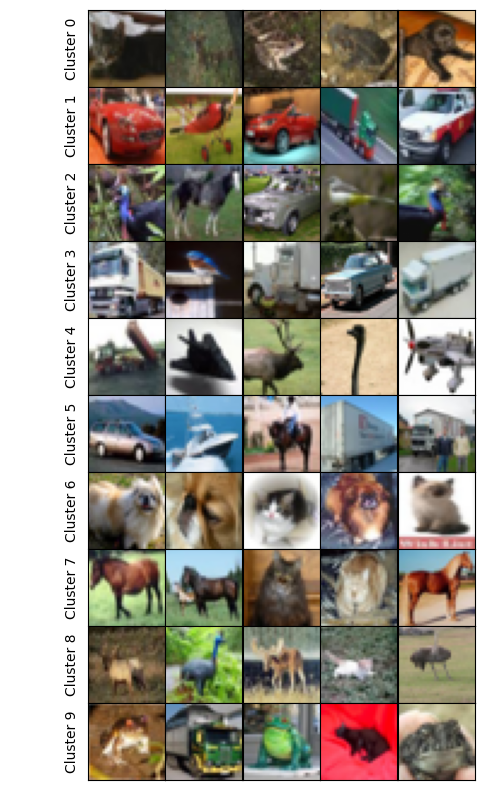

In [5]:
import matplotlib.pyplot as plt
num_samples_to_show = 5
# Calculate number of rows and columns for the grid
num_cols = num_samples_to_show + 1  # Add one column for text
num_rows = k
total_images = num_cols*num_rows

# Create a single axis
fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

# Flatten the axis array to simplify indexing
ax = ax.flatten()

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# Remove border of the first column
for i in range(0, total_images, num_cols):
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

for cluster_id in range(k):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    num_samples = min(len(cluster_indices), 5)  # Limit to at most 5 samples per cluster
    for i, idx in enumerate(cluster_indices[:num_samples]):
        img, _ = cifar10_train[idx]
        img = img / 2 + 0.5  # Unnormalize
        img = np.transpose(img.numpy(), (1, 2, 0))
        ax[cluster_id * num_cols + i + 1].imshow(img)

# Add text for each row in a new column at the front
for cluster_id in range(k):
    ax[cluster_id * num_cols].text(0.8, 0.5, f'Cluster {cluster_id}', ha='center', va='center', rotation=90)

plt.subplots_adjust(wspace=0, hspace=0)  # Remove space between subplots
plt.savefig('clustering perceptual.png')
plt.show()
